In [168]:
%matplotlib inline
from marketdata import *
from model import *
from analytics import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

# Load data 


In [169]:
FundAUM=1e6

In [170]:
mkts=get_market_list()
curr_px=get_most_liquid_price(mkts)
df=pd.DataFrame()
for m in mkts:
    df[m]=get_timeseries(m)

# Portfolio with two different look backs with standard breakout models

* Models with 10 days and 80 days have the most diversification thus the most reduced drawdown

In [171]:
pos=tsmom_daily(df[mkts],10)
pnl_short=calc_pnl_wc(pos,df[mkts])
pos=tsmom_daily(df[mkts],80)
pnl_long=calc_pnl_wc(pos,df[mkts])
combined_pnl=(pnl_short*.5+pnl_long*.5)
scaling_factor=calc_scaling_factor(combined_pnl)
s_short=tsmom_daily_signal(df,10)
s_long=tsmom_daily_signal(df,80)
s_combined = (s_short*.5+s_long*.5)
lots=calc_position(s_combined,FundAUM,scaling_factor,curr_px)

In [172]:
mul=get_contract_multipliers()[df.columns]
cost=cost_model_position(lots,curr_px,mul,fee=0.0003)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


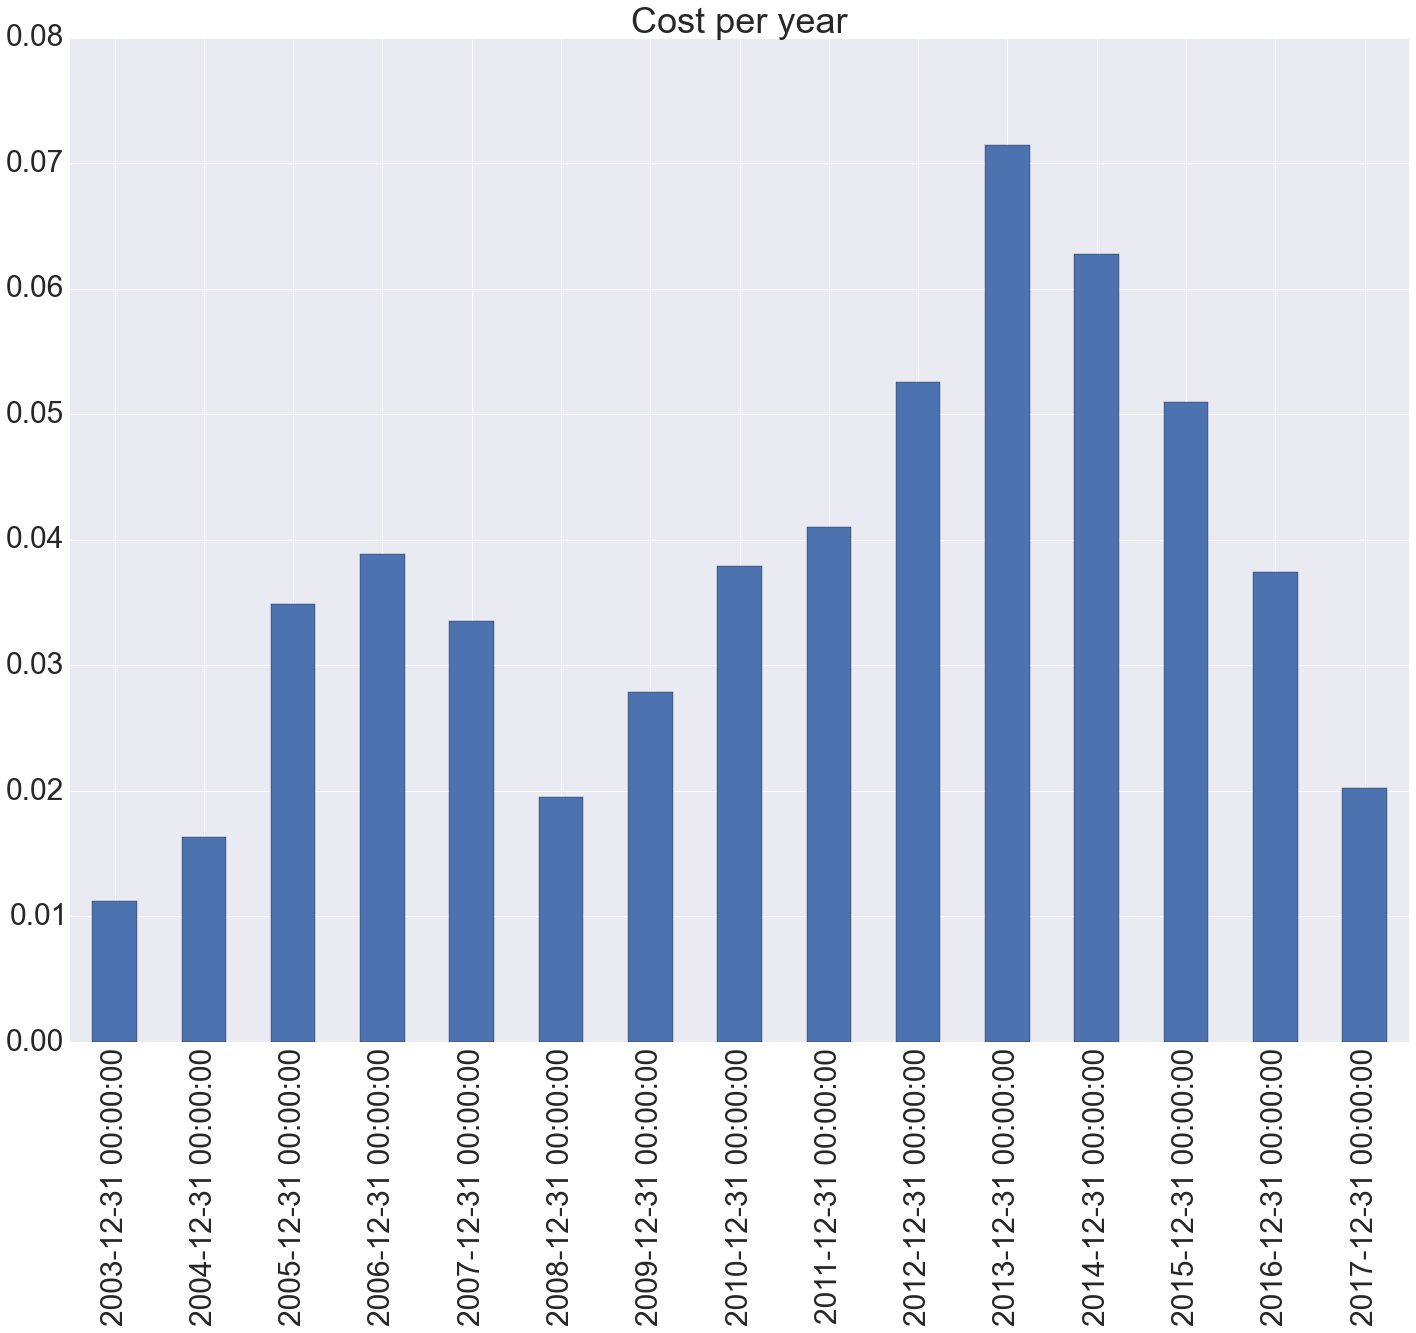

In [173]:
(cost.sum(axis=1).resample(rule='a',how='sum')/FundAUM).plot(kind='bar',title='Cost per year')

In [174]:
PNL = calc_pnl_position_wc(lots,df,curr_px,0.0003)/FundAUM

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


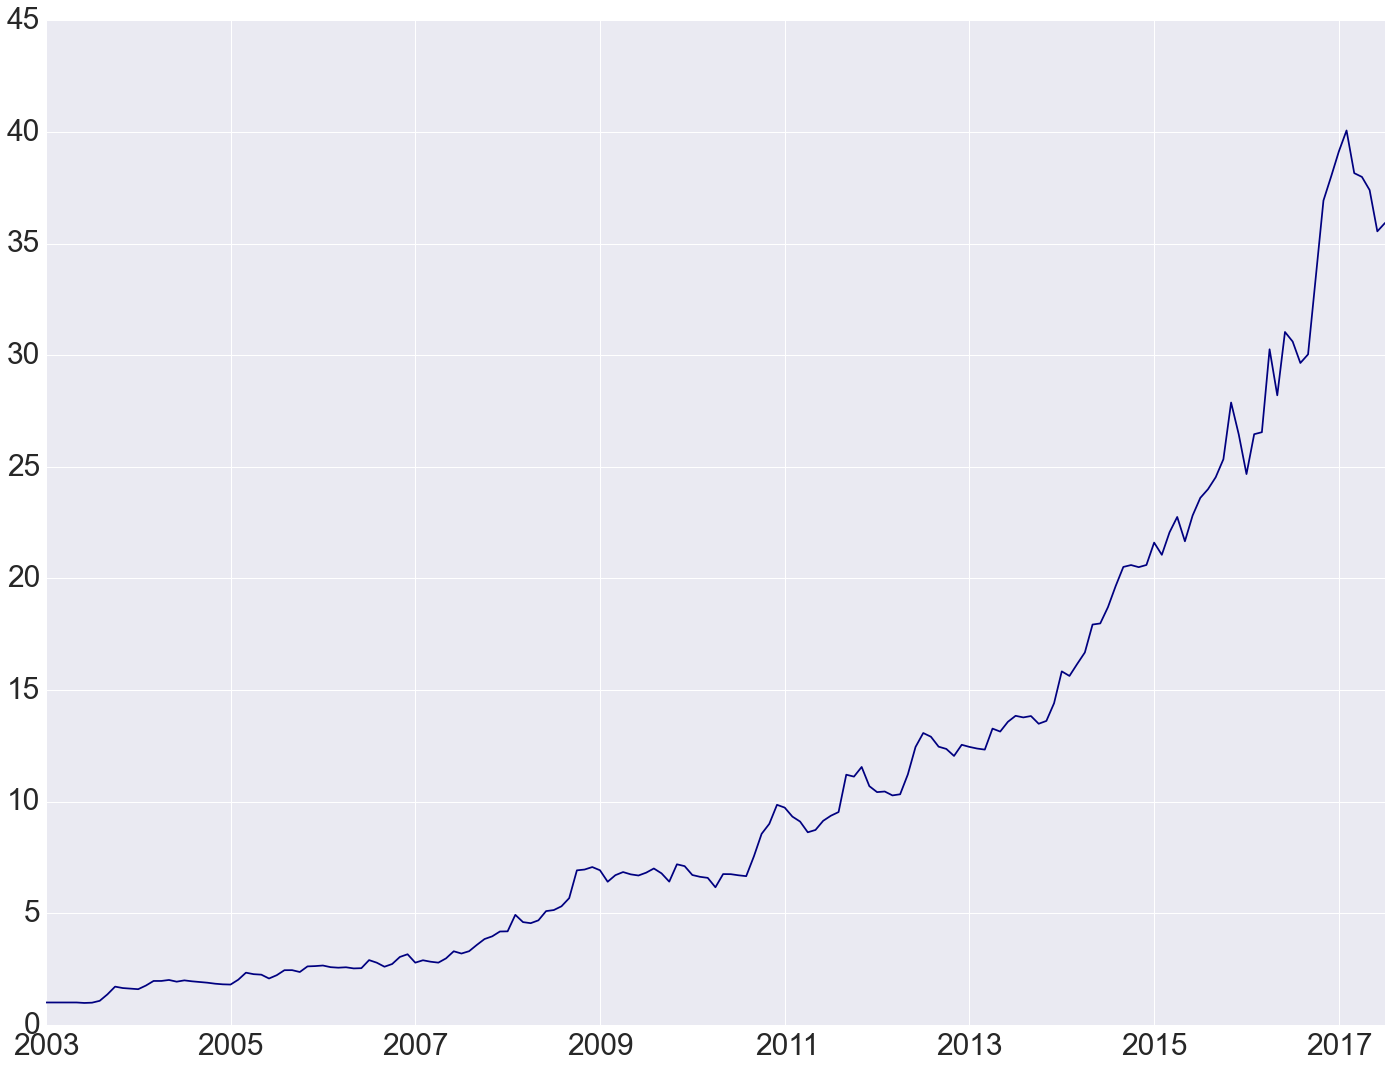

In [175]:
(PNL.sum(axis=1).resample(rule='m',how='sum')+1).cumprod().plot(colormap='jet')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


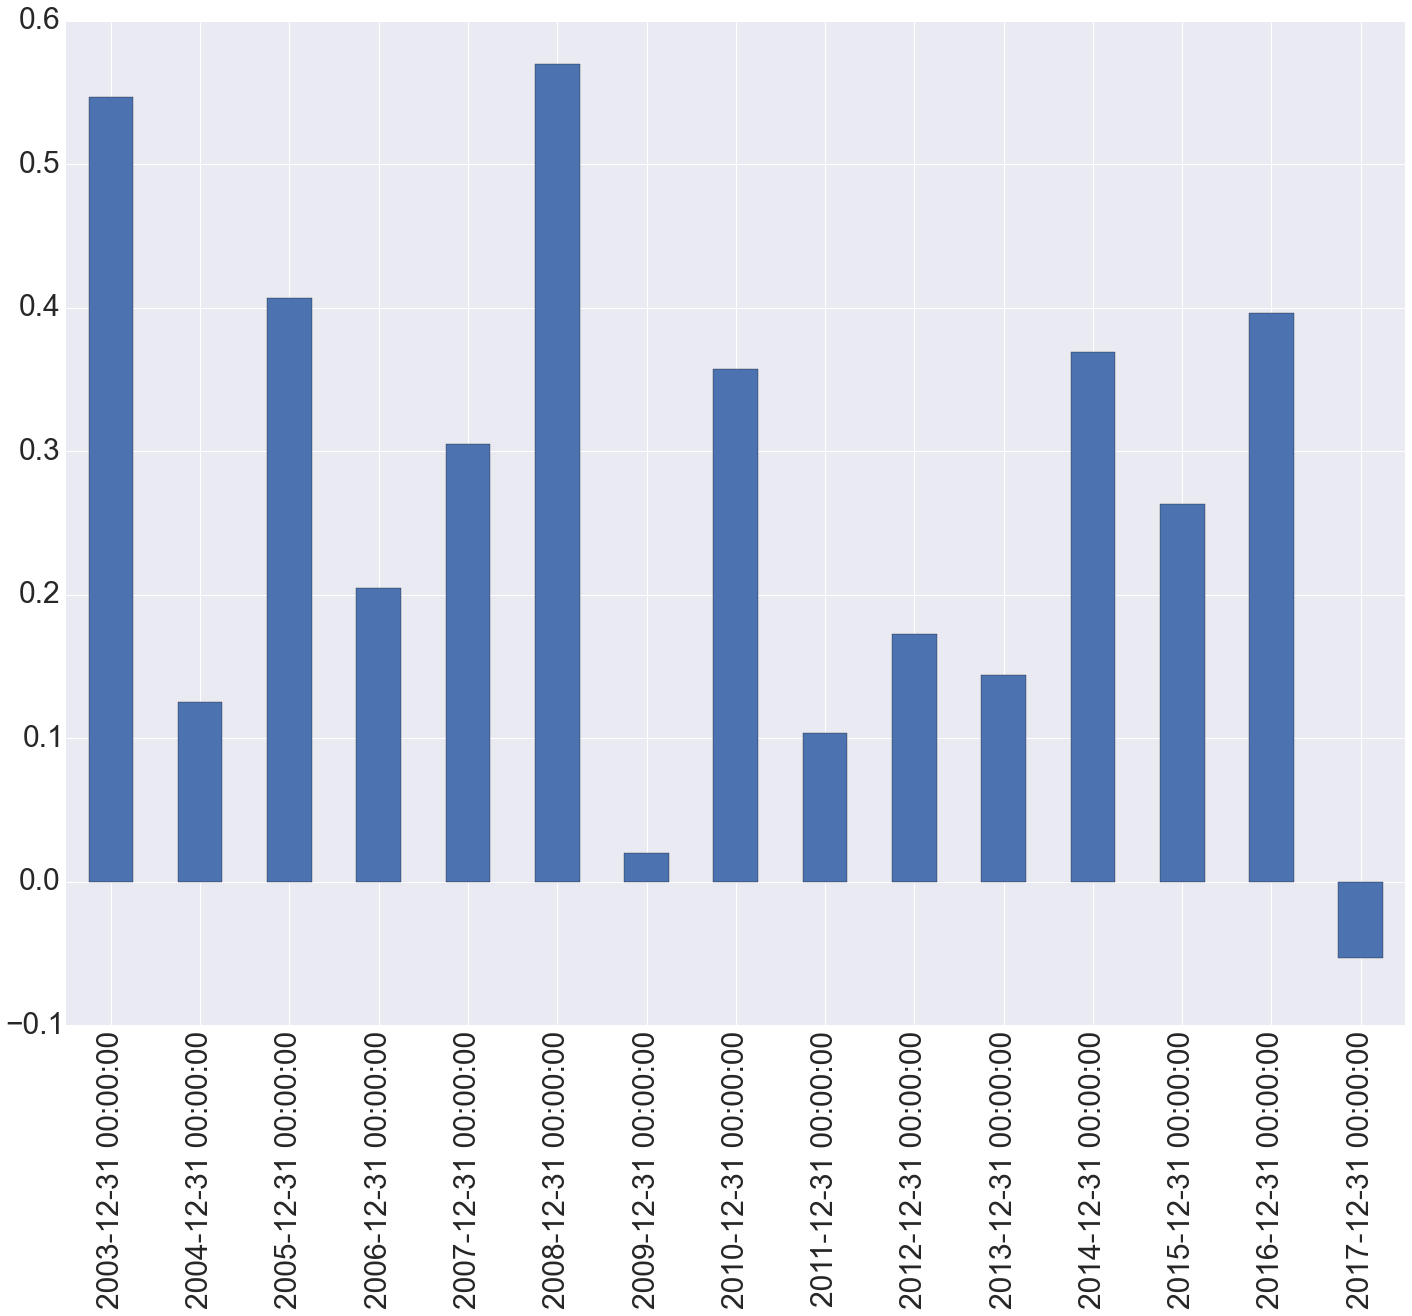

In [176]:
PNL.sum(axis=1).resample(rule='m',how='sum').resample(rule='a',how='sum').plot(kind='bar')

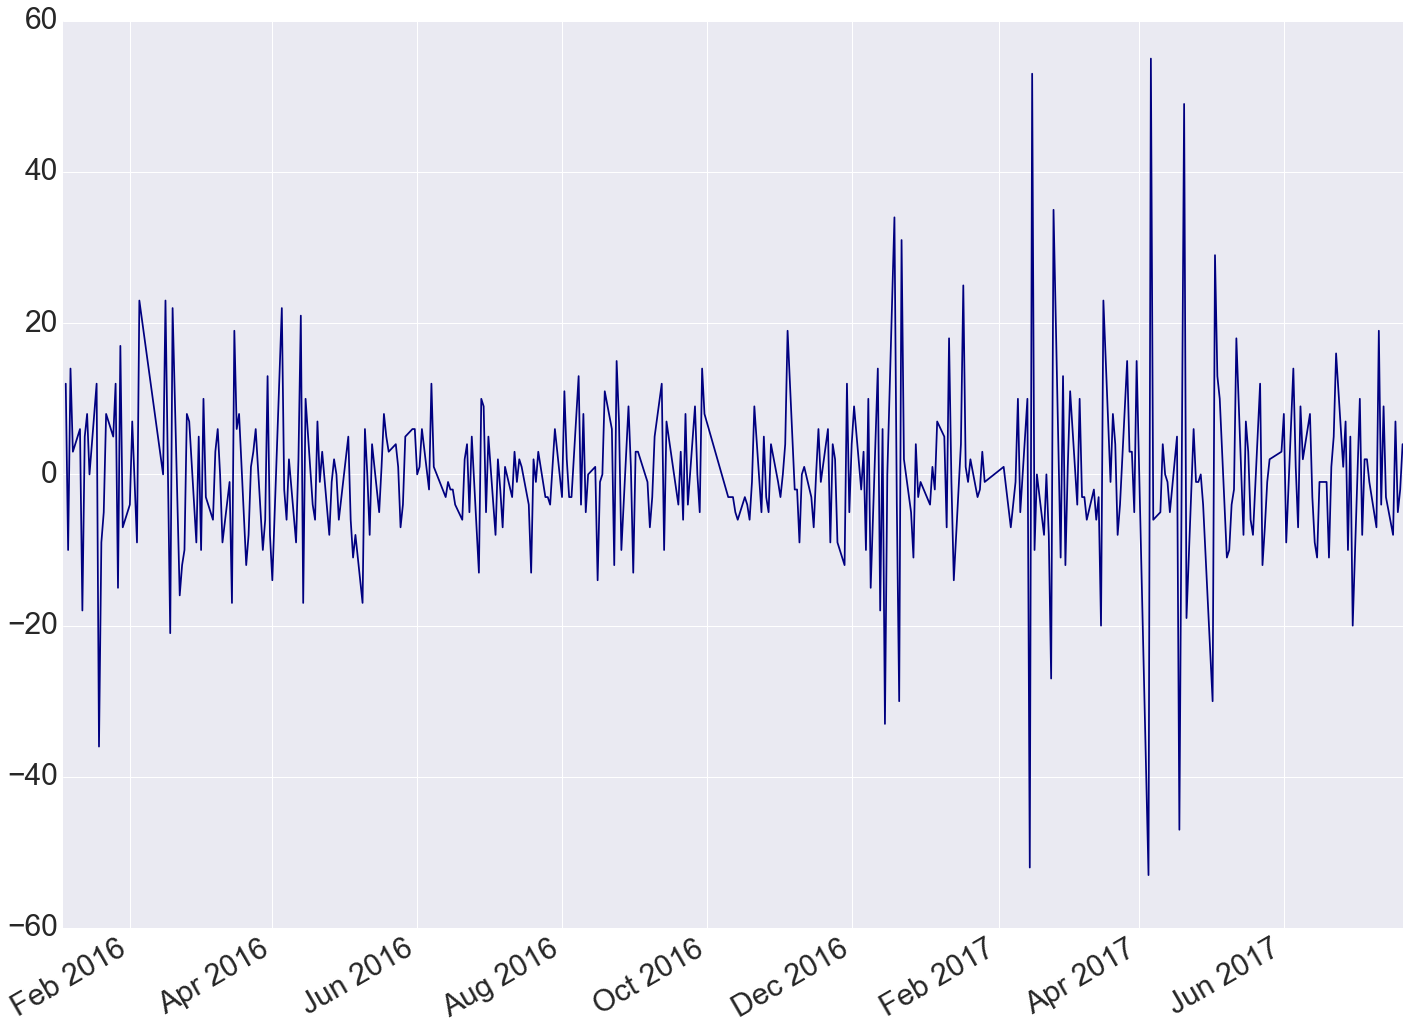

In [177]:
lots['2016':].abs().sum(axis=1).ffill().diff().plot(colormap='jet')

# Calculating fees

In [238]:
management_fee = 0.015
performance_fee = 0.2

In [239]:
gross_pnl=PNL.dropna(how='all').sum(axis=1).resample(rule='m',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


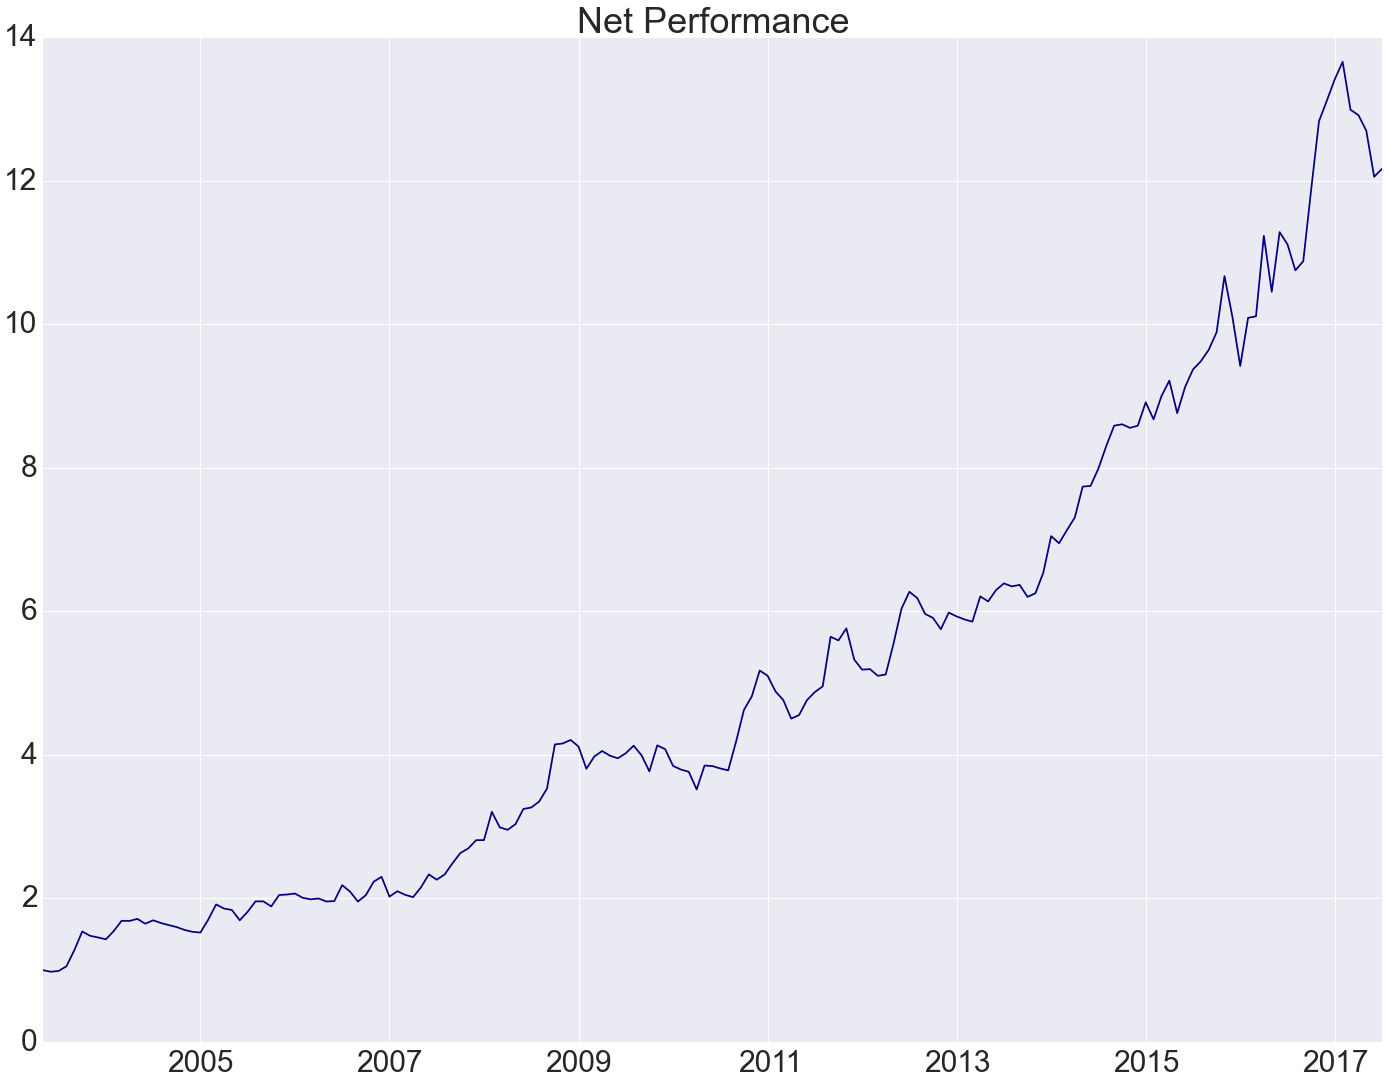

In [240]:
calc_net_performance(gross_pnl,management_fee,performance_fee).plot(colormap='jet',title='Net Performance')

In [241]:
x=calc_net_performance(gross_pnl,management_fee,performance_fee)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


In [242]:
import math
x['2005':].pct_change().std()*math.sqrt(12)


0.17536557927810056

In [243]:
x.count()/12.0

14.25

In [244]:
x.tail()

2017-03-31    12.991488
2017-04-30    12.917492
2017-05-31    12.700677
2017-06-30    12.057060
2017-07-31    12.169536
dtype: float64

In [245]:
12.17**(1/14.25)

1.1916829955755617